<a href="https://colab.research.google.com/github/Danish-Hussain-DSAI/deepfake-image-classifier-on-DenseNet121-20-epochs/blob/main/latest20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7za -y x "/content/drive/MyDrive/archive (12).zip"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 4024555718 bytes (3839 MiB)

Extracting archive: /content/drive/MyDrive/archive (12).zip
  2% 4096 Open               26% 36864 Open                43% 61440 Open                55% 77824 Open               --
Path = /content/drive/MyDrive/archive (12).zip
Type = zip
Physical Size = 4024555718
64-bit = +

  0%      0% 313 - real_vs_fake/real-vs-fake/test/fake/119BGZWRCM.jpg                                                             

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [ ]:
image_path = '/content/real_vs_fake/real-vs-fake'

train_dir = image_path + '/train'
valid_dir = image_path + '/valid'
test_dir = image_path + '/test'

In [ ]:
from pathlib import Path

train_path = Path(train_dir)
valid_path = Path(valid_dir)
test_path = Path(test_dir)

print("Train_dir Subfolders: ", [subfolder.name for subfolder in train_path.iterdir() if subfolder.is_dir()])
print("Valid_dir Subfolders: ", [subfolder.name for subfolder in valid_path.iterdir() if subfolder.is_dir()])
print("Test_dir Subfolders: ", [subfolder.name for subfolder in test_path.iterdir() if subfolder.is_dir()])

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [ ]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

# Iterate over each train, valid, and test folder
for folder in ['train', 'valid', 'test']:
    # Iterate over fake and real folders (labels)
    for label in ['fake', 'real']:
        # Iterate over images with .jpg extension in the current label folder
        for img in glob.glob(f"{image_path}/{folder}/{label}/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [ ]:
images_df = pd.DataFrame(images_df)

In [ ]:
images_df

,folder,image_path,label
0,train,/content/real_vs_fake/real-vs-fake/train/fake/...,fake
1,train,/content/real_vs_fake/real-vs-fake/train/fake/...,fake
2,train,/content/real_vs_fake/real-vs-fake/train/fake/...,fake
3,train,/content/real_vs_fake/real-vs-fake/train/fake/...,fake
4,train,/content/real_vs_fake/real-vs-fake/train/fake/...,fake
...,...,...,...
139995,test,/content/real_vs_fake/real-vs-fake/test/real/5...,real
139996,test,/content/real_vs_fake/real-vs-fake/test/real/1...,real
139997,test,/content/real_vs_fake/real-vs-fake/test/real/0...,real
139998,test,/content/real_vs_fake/real-vs-fake/test/real/4...,real


In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [ ]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [ ]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [ ]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
train_ds = image_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=200,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=200,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=200,
    class_mode='binary',
    shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

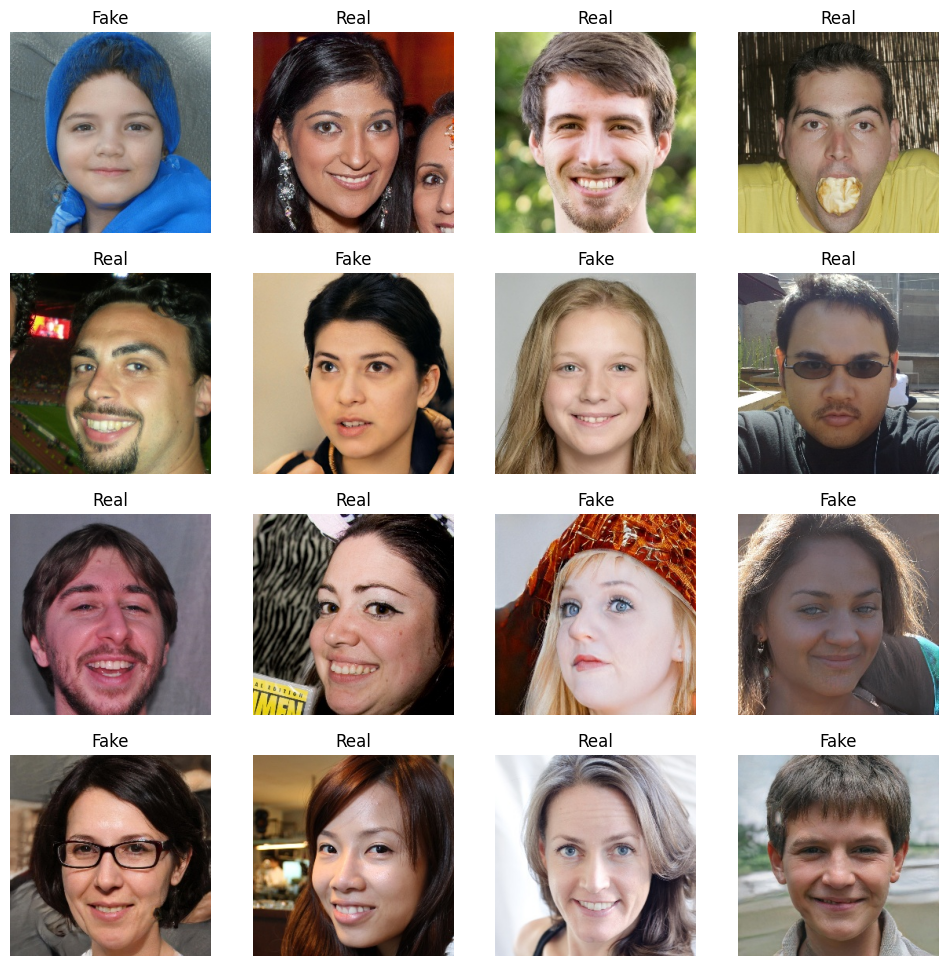

In [ ]:
img,lbl = next(train_ds)
plot_images(img,lbl)

In [ ]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.69411767 0.7019608  0.454902  ]
  [0.6901961  0.69803923 0.4431373 ]
  [0.6862745  0.69803923 0.427451  ]
  ...
  [0.6627451  0.6745098  0.39607847]
  [0.67058825 0.68235296 0.41176474]
  [0.6862745  0.69803923 0.427451  ]]

 [[0.69803923 0.7058824  0.45098042]
  [0.69803923 0.7058824  0.45098042]
  [0.69411767 0.7058824  0.43529415]
  ...
  [0.67058825 0.68235296 0.4039216 ]
  [0.6666667  0.6784314  0.40784317]
  [0.6784314  0.6901961  0.41960788]]

 [[0.6901961  0.70980394 0.44705886]
  [0.6901961  0.70980394 0.44705886]
  [0.6862745  0.7058824  0.4431373 ]
  ...
  [0.6745098  0.69803923 0.4156863 ]
  [0.6666667  0.6901961  0.40784317]
  [0.6666667  0.6901961  0.40784317]]

 ...

 [[0.77647066 0.7960785  0.6784314 ]
  [0.7686275  0.78823537 0.6627451 ]
  [0.7725491  0.7843138  0.6627451 ]
  ...
  [0.5019608  0.3254902  0.21176472]
  [0.57254905 0.40000004 0.28627452]
  [0.54901963 0.37647063 0.2627451 ]]

 [[0.77647066 0.78823537 0.68235296]
  [0.7686275  0.7803922  0.6

In [ ]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(200, 256, 256, 3)
(200,)


In [ ]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

In [ ]:
# Load the pre-trained DenseNet121 model without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
# Train the model with data augmentation
hostory=model.fit(
    train_ds,
    epochs = 20,
    validation_data=valid_ds,
)

Epoch 1/20
500/500 [==============================] - 498s 940ms/step - loss: 0.4437 - accuracy: 0.7894 - val_loss: 0.3721 - val_accuracy: 0.8324
Epoch 2/20
500/500 [==============================] - 458s 915ms/step - loss: 0.3422 - accuracy: 0.8506 - val_loss: 0.3352 - val_accuracy: 0.8524
Epoch 3/20
500/500 [==============================] - 466s 931ms/step - loss: 0.3042 - accuracy: 0.8688 - val_loss: 0.3780 - val_accuracy: 0.8255
Epoch 4/20
500/500 [==============================] - 457s 913ms/step - loss: 0.2785 - accuracy: 0.8821 - val_loss: 0.2918 - val_accuracy: 0.8749
Epoch 5/20
500/500 [==============================] - 450s 900ms/step - loss: 0.2568 - accuracy: 0.8923 - val_loss: 0.2659 - val_accuracy: 0.8891
Epoch 6/20
500/500 [==============================] - 449s 897ms/step - loss: 0.2359 - accuracy: 0.9024 - val_loss: 0.2432 - val_accuracy: 0.8969
Epoch 7/20
500/500 [==============================] - 455s 910ms/step - loss: 0.2259 - accuracy: 0.9062 - val_loss: 0.2342 -

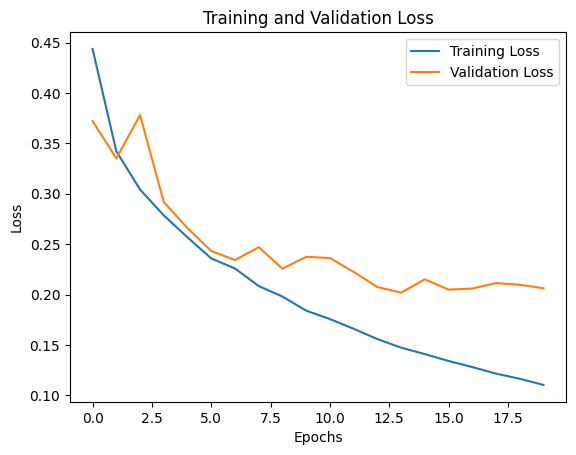

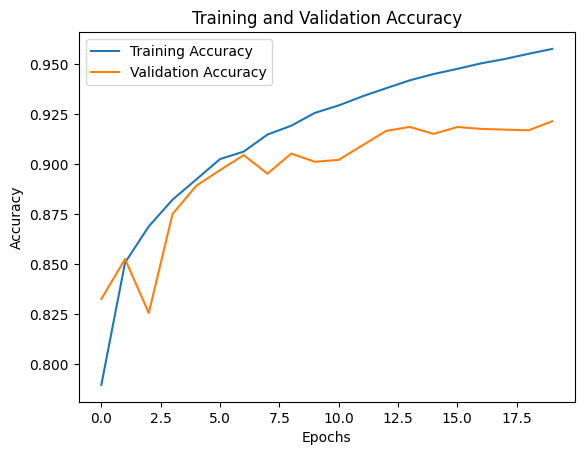

In [ ]:
import matplotlib.pyplot as plt

# Train vs Validation Loss
plt.plot(hostory.history['loss'], label='Training Loss')
plt.plot(hostory.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.plot(hostory.history['accuracy'], label='Training Accuracy')
plt.plot(hostory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

100/100 [==============================] - 75s 748ms/step - loss: 0.2103 - accuracy: 0.9164
Test Loss: 0.21032431721687317
Test Accuracy: 0.9164000153541565
100/100 [==============================] - 76s 744ms/step
Confusion Matrix:
[[9035  965]
 [ 707 9293]]


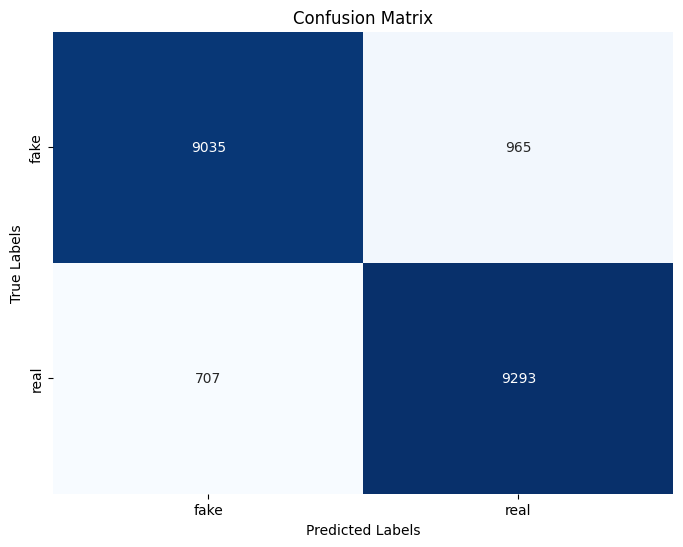

In [ ]:
from sklearn.metrics import confusion_matrix
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate predictions for test data
predictions = model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels from test data generator
y_true = test_ds.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_ds.class_indices.keys(),
            yticklabels=test_ds.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
